## Problem Definition 

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier  
#from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler,SMOTE
from collections import Counter
import warnings
warnings.filterwarnings("ignore")


from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler


## Data Insights 

In [2]:
df = pd.read_csv('Loan_Default.csv')
df.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [ ]:
df.describe()

Find the number of null values for each column 

In [4]:
df.isnull().sum()


ID                               0
year                             0
loan_limit                    3344
Gender                           0
approv_in_adv                  908
loan_type                        0
loan_purpose                   134
Credit_Worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
rate_of_interest             36439
Interest_rate_spread         36639
Upfront_charges              39642
term                            41
Neg_ammortization              121
interest_only                    0
lump_sum_payment                 0
property_value               15098
construction_type                0
occupancy_type                   0
Secured_by                       0
total_units                      0
income                        9150
credit_type                      0
Credit_Score                     0
co-applicant_credit_type         0
age                            200
submission_of_applic

In [ ]:
(df.isnull().sum()/len(df))*100

Find the duplicates 

In [12]:
df.duplicated().value_counts()

False    148670
dtype: int64

In [3]:
df.drop_duplicates(inplace=True)

## Data Insights- Visualizations

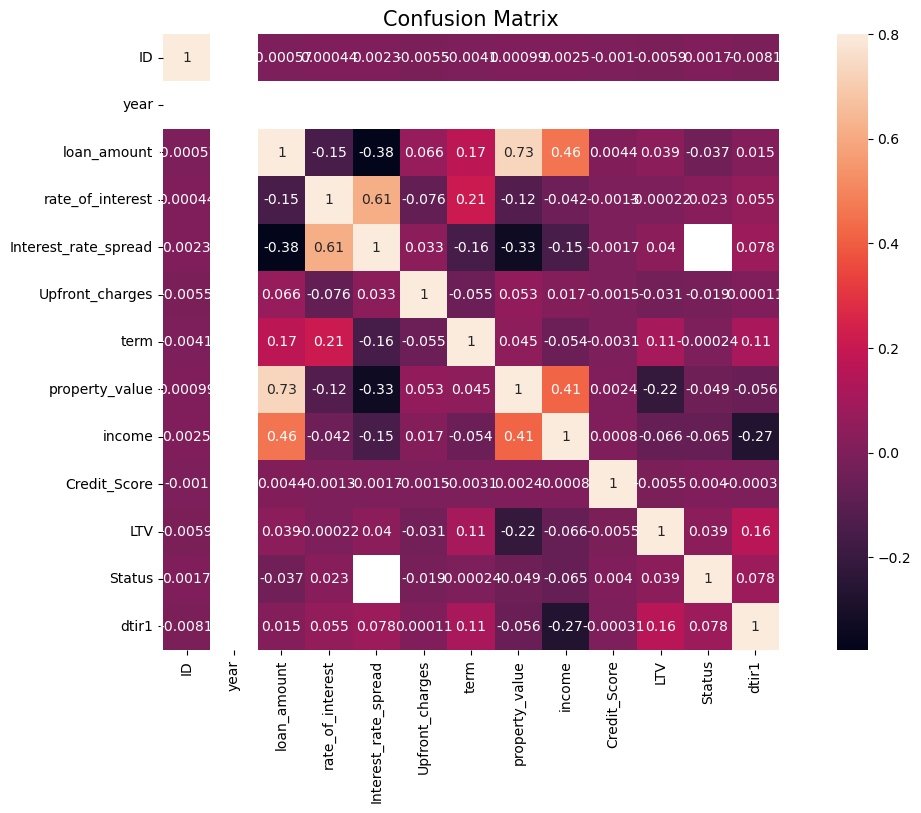

In [5]:
df.corr()
fig, ax = plt.subplots() 
fig.set_size_inches(15,8)
sns.heatmap(df.corr(), vmax =.8, square = True, annot = True )
plt.title('Confusion Matrix',fontsize=15);

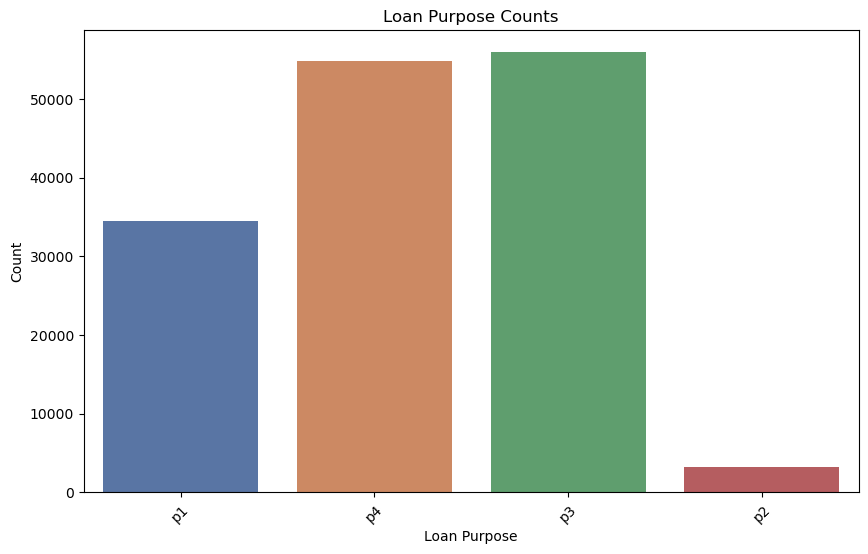

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='loan_purpose', palette='deep')
plt.title('Loan Purpose Counts')
plt.xlabel('Loan Purpose')
plt.ylabel('Count')
plt.xticks(rotation=45)  

# Show the plot
plt.show()


In [ ]:

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='person_home_ownership', palette='deep')
plt.title('Applicant Home Ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Count')
plt.xticks(rotation=45)  

# Show the plot
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='cb_person_cred_hist_length', palette='deep')
plt.title('Applicant Credit History')
plt.xlabel('Credit History')
plt.ylabel('Count')
plt.xticks(rotation=45)  

# Show the plot
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='loan_intent', palette='deep')
plt.title('Applicant Loan Intent')
plt.xlabel('Loan Intent')
plt.ylabel('Count')
plt.xticks(rotation=45)  

# Show the plot
plt.show()

## Target values 

In [8]:
df["Status"].value_counts()

0    112031
1     36639
Name: Status, dtype: int64

In [ ]:
df["loan_status"].value_counts(normalize=True)

So the data is imbalance and we need to consider this for modelling steps. 

## Preprocessing 

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Assuming df is your dataframe and 'Status' is the target variable
X = df.drop(['ID', 'Status'], axis=1)
y = df['Status']

# Identify categorical columns that need to be encoded
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Define transformers
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define a pipeline that first preprocesses the data and then fits the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=0))
])

# Split the dataset into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Get feature importances
feature_importances = pipeline.named_steps['classifier'].feature_importances_
feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names(input_features=categorical_cols)

# Combine feature importances with their corresponding feature names
importances = dict(zip(feature_names, feature_importances))

# Sort the feature importances in descending order and print them
sorted_importances = sorted(importances.items(), key=lambda item: item[1], reverse=True)
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")


Gender_Male: 0.26945274320295154
Gender_Joint: 0.2646983849812809
Gender_Female: 0.153055251357335
submission_of_application_not_inst: 0.13736419430096225
loan_type_type2: 0.036677245628550424
loan_type_type3: 0.021707969384373627
approv_in_adv_nopre: 0.02072775414878029
approv_in_adv_pre: 0.009344956601294415
Region_North-East: 0.005990409743168722
loan_limit_ncf: 0.0059554285158690415
Secured_by_home: 0.005729938983250188
total_units_4U: 0.005243174877418852
total_units_3U: 0.004901729549278514
Secured_by_land: 0.004382734608808709
Region_North: 0.0038223812091486846
occupancy_type_sr: 0.0029845518124769744
business_or_commercial_nob/c: 0.0026871319989866626
age_<25: 0.002626033833231636
loan_type_type1: 0.002261790502847776
Gender_Sex Not Available: 0.002206503410432004
Neg_ammortization_neg_amm: 0.0021747671167121245
occupancy_type_pr: 0.0021021776439337954
age_>74: 0.0020157258032124773
loan_purpose_p4: 0.0019860753727153607
submission_of_application_to_inst: 0.0019857733012843834

## Data Cleaning  
Due to ethical considerations and potential legal restrictions (like those from the Equal Credit Opportunity Act in the U.S.), using gender as a predictor in loan default models is generally discouraged and could be considered discriminatory.

In [9]:
df['age'] = df['age'].str.extract('(\d+)').astype(float)

In [5]:
df.columns = [col.lower() for col in df.columns]
print(df.columns)

Index(['id', 'year', 'loan_limit', 'gender', 'approv_in_adv', 'loan_type',
       'loan_purpose', 'credit_worthiness', 'open_credit',
       'business_or_commercial', 'loan_amount', 'rate_of_interest',
       'interest_rate_spread', 'upfront_charges', 'term', 'neg_ammortization',
       'interest_only', 'lump_sum_payment', 'property_value',
       'construction_type', 'occupancy_type', 'secured_by', 'total_units',
       'income', 'credit_type', 'credit_score', 'co-applicant_credit_type',
       'age', 'submission_of_application', 'ltv', 'region', 'security_type',
       'status', 'dtir1'],
      dtype='object')


In [6]:
columns_to_drop = ['id', 'year', 'gender']
# Drop the columns
df_dropped = df.drop(columns=columns_to_drop)

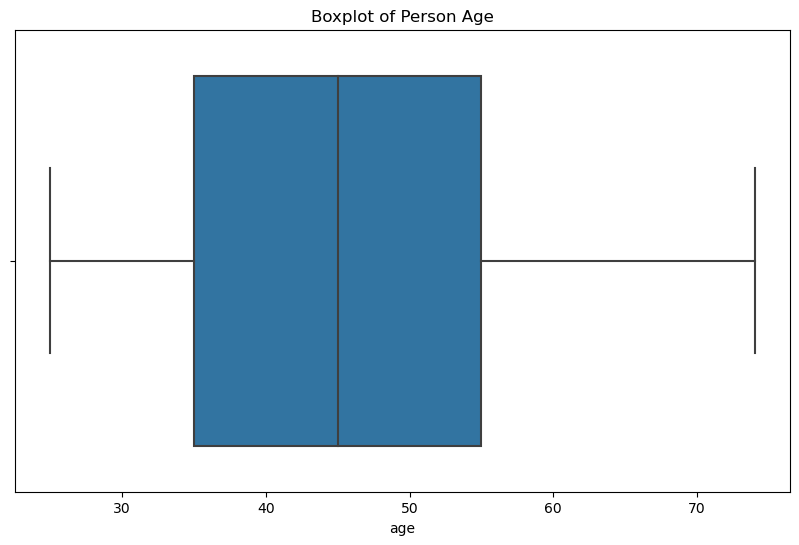

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# This code assumes that 'age' is a numerical column in your DataFrame `df`.
# If 'age' is represented differently, you'll need to preprocess it into numerical form.

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['age'])  # Make sure 'age' is the correct column name
plt.title('Boxplot of Person Age')
plt.xlabel('age')
plt.show()


In [5]:
df['loan_to_income_ratio'] = df['loan_amnt'] / df['person_income']

 Some data entry issues

In [6]:
 #Find numerical columns in the DataFrame
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Find categorical columns in the DataFrame
categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# Output the findings
print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

Numerical Columns: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_cred_hist_length', 'loan_to_income_ratio']
Categorical Columns: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


In [ ]:
print("Columns in the DataFrame:", df.columns)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline



# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('loan_status', axis=1),  # Drop the target variable to create features
    df['loan_status'],               # Target variable
    random_state=0,                  # Ensures reproducibility
    test_size=0.2,                   # Proportion of dataset to include in test split
    stratify=df['loan_status'],      # Ensures train and test sets have similar class distributions
    shuffle=True                     # Shuffles the data before splitting
)

# Define categorical and numerical features
categorical_features = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create the preprocessing pipelines for both numerical and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a pipeline that combines the preprocessor with a RandomForest classifier
model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the RandomForest model
model_pipeline.fit(X_train, y_train)




Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length',
                                                   'loan_to_income_ratio']),
                                               

In [9]:
from sklearn.model_selection import GridSearchCV
# Define a grid of hyperparameters to search over
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
}

# Create a GridSearchCV object to perform hyperparameter tuning
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Output the best parameters found by GridSearchCV
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


              precision    recall  f1-score   support

           0       0.93      0.98      0.96      5062
           1       0.92      0.74      0.82      1418

    accuracy                           0.93      6480
   macro avg       0.92      0.86      0.89      6480
weighted avg       0.93      0.93      0.93      6480

F1 Score: 0.8175411119812059
ROC AUC Score: 0.930725436185099


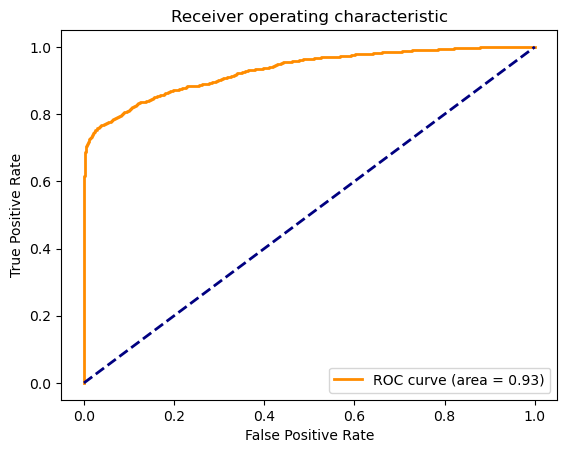

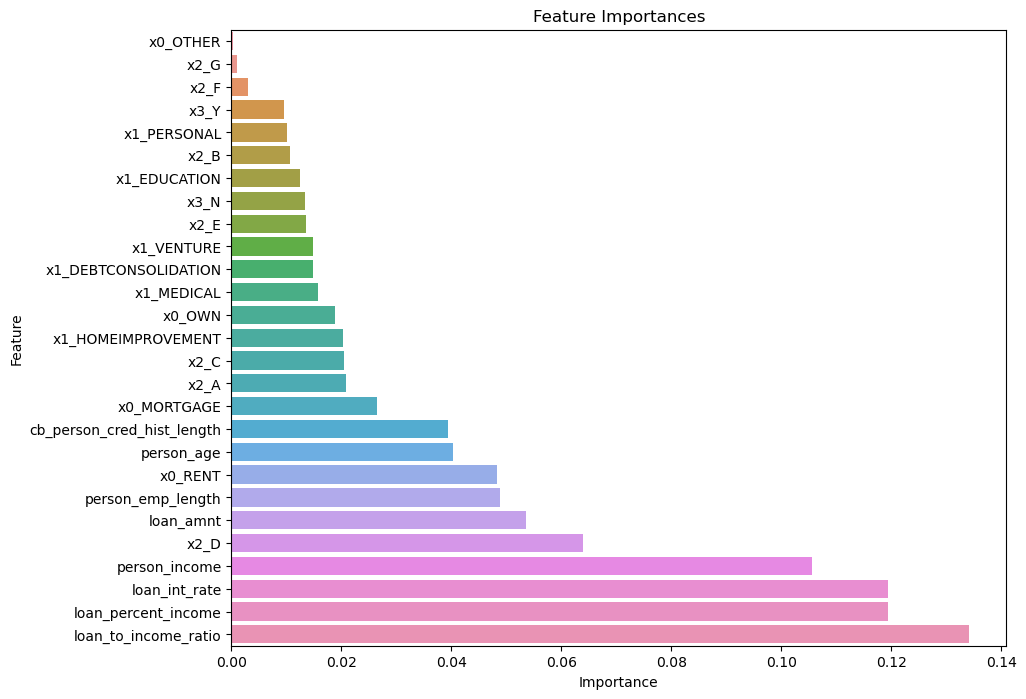

In [12]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Use the best hyperparameters to create a new pipeline
best_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42))
])

# Fit the pipeline with the best hyperparameters
best_pipeline.fit(X_train, y_train)

# Evaluate the model with the test data
y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:, 1]

# Calculate evaluation metrics
print(classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Generate ROC curve values
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Feature Importances - extraction from the pipeline
feature_importances = best_pipeline.named_steps['classifier'].feature_importances_
# Get feature names from the preprocessor
# Note: This will only work with versions of scikit-learn where OneHotEncoder has a get_feature_names method
# Retrieve the right transformer
categorical_transformer = best_pipeline.named_steps['preprocessor'].named_transformers_['cat']

# Get the feature names for categorical features
cat_feature_names = categorical_transformer.named_steps['onehot'].get_feature_names_out()

# Combine with numerical features to get all feature names
feature_names = np.concatenate((numerical_features, cat_feature_names))

# Adjust the indices to match the length of feature names
indices = np.argsort(feature_importances)[::-1]

# Plot the feature importances
# Sort importances and corresponding feature names
sorted_indices = np.argsort(feature_importances)
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Now create the bar plot with Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_importances, y=sorted_features)

plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.show()



Debt Burden: The loan-to-income ratio reflects the debt burden on the borrower relative to their income. A higher ratio indicates that a significant portion of the borrower's income is needed to service debt, which could increase the risk of default.

Repayment Capacity: It directly measures the borrower's capacity to repay. If a large portion of their income is already allocated to loan repayments, any financial stress could lead to default.

In [ ]:
print(sorted_features)

## logistic regression 

In [18]:
## Create the logistic regression pipeline
lr_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Define a set of hyperparameters to test
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear'],  # 'liblinear' works well with small datasets and 'l1' penalty
}

# Create a GridSearchCV object
grid_search_lr = GridSearchCV(lr_pipeline, param_grid, cv=5, scoring='roc_auc', verbose=1)

# Fit the GridSearchCV object to the training data
grid_search_lr.fit(X_train, y_train)

# Get the best parameters and the best score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score (ROC AUC):", grid_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best score (ROC AUC): 0.8776152845048962


In [19]:

# Evaluate the best model on the test set
best_model_lr = grid_search_lr.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Print out evaluation metrics
print(classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.93      0.82      0.87      5062
           1       0.55      0.79      0.65      1418

    accuracy                           0.82      6480
   macro avg       0.74      0.81      0.76      6480
weighted avg       0.85      0.82      0.83      6480

F1 Score: 0.6507288629737609
ROC AUC Score: 0.8782843098191732


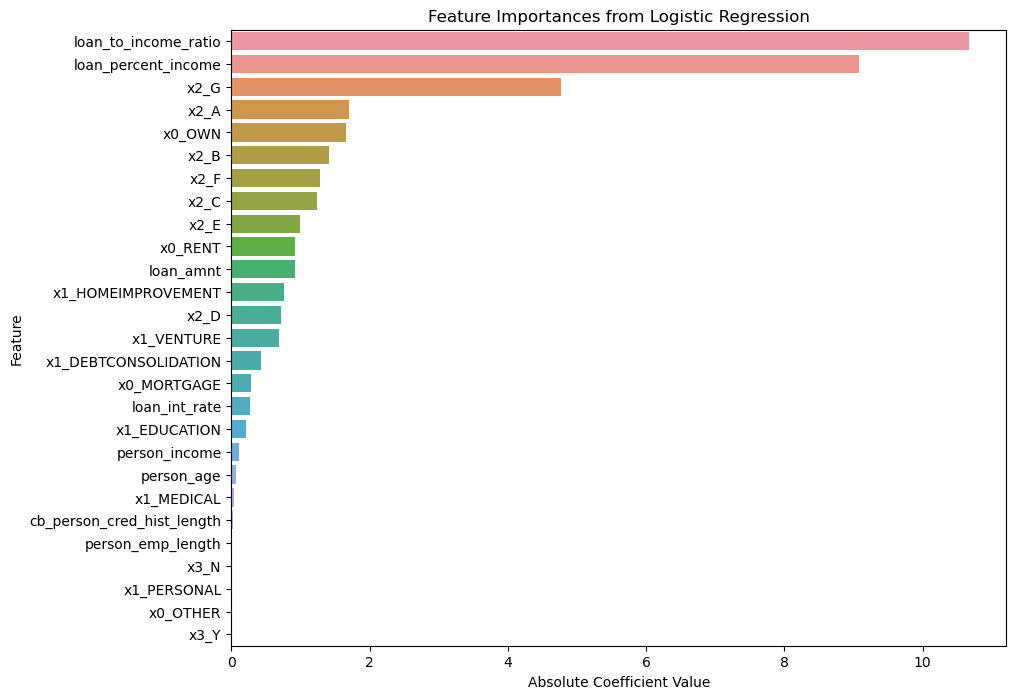

In [20]:
# Assuming that you have a trained model 'best_model_lr' and a list of feature names 'feature_names'
coefs = best_model_lr.named_steps['classifier'].coef_[0]
feature_importances = pd.Series(coefs, index=feature_names)

# Sort the features by their importance (absolute value)
sorted_features = feature_importances.abs().sort_values(ascending=False)

# Plot the feature importances using seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_features.values, y=sorted_features.index)
plt.title('Feature Importances from Logistic Regression')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.show()

## Decision Trees:


SyntaxError: invalid syntax (2115441868.py, line 1)